In [753]:
## load the packages here
# import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics

import statsmodels.api as sm 
from statsmodels.discrete.discrete_model import Logit

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import copy
# import GridSearchCV from sklearn
from scipy.special import expit

In [755]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF = pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = d['Events'] / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = d['Non-Events'] / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars],
                            "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF

## Task 1: Download your data and load them into the Python.
You can find them [**here**](https://drive.google.com/file/d/0Bz9_0VdXvv9bX0MzUEhVdmpCc3c/view?usp=sharing).

- Features and response variables are in different files
- be careful about number of spaces between the values in the file

In [790]:
feature_names = pd.read_csv('Smartphone_Sensor_Data/features.txt', sep=" ", header=None, engine='python')

In [791]:
features = pd.read_csv('Smartphone_Sensor_Data/train/X_train.txt', sep="  | ", header=None, engine='python')

In [792]:
targets = pd.read_csv('Smartphone_Sensor_Data/train/y_train.txt', header=None, engine='python')

In [793]:
features

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [797]:
features.columns = list(feature_names[1])

In [798]:
features

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


## Task 2: Create Binary target variable: categories 1,2,3 --> 1, categories 4,5,6 --> 0 
This will represent binary variable indicating if person is walking or not

In [652]:
group_1 = [1,2,3]

In [653]:
targets['binary'] = np.where(np.isin(targets[0],group_1),1,0)

In [654]:
targets[0].unique()

array([5, 4, 6, 1, 3, 2])

In [655]:
targets

,0,binary
0,5,0
1,5,0
2,5,0
3,5,0
4,5,0
...,...,...
7347,2,1
7348,2,1
7349,2,1
7350,2,1


## Task 3

+ Create Univariate Binary Logistic Regression with feature number 54, which represents `tGravityAcc-min()-Y`: gravity acceleration signals in direction of Y
+ Compare the results of Logistic regressions from different Python packages (sklearn, statsmodel)
+ Plot the FIT of predicted probabilities to the original values

### Sklearn LogisticRegression

In [656]:
x_1 = features[54].values.reshape(-1,1)
y = targets['binary'].values

In [657]:
log_reg = LogisticRegression()
log_reg.fit(x_1,y)
y_pred=log_reg.predict(x_1)

In [658]:
log_reg.coef_

array([[-4.08782292]])

In [659]:
cnf_matrix = metrics.confusion_matrix(y, y_pred)
cnf_matrix

array([[2999, 1068],
       [1055, 2230]])

In [660]:
print("Accuracy:",metrics.accuracy_score(y, y_pred))    
print("Precision:",metrics.precision_score(y, y_pred))   
print("Recall:",metrics.recall_score(y, y_pred))         

Accuracy: 0.7112350380848749
Precision: 0.6761673741661614
Recall: 0.6788432267884322


### Statsmodels

In [661]:
log_reg_sm = sm.Logit(y, x_1).fit() 

Optimization terminated successfully.
         Current function value: 0.549391
         Iterations 6


In [662]:
# predicts the probabilities not the actual categories
yhat = log_reg_sm.predict(x_1) 
prediction = list(map(round, yhat)) 

In [663]:
print(log_reg_sm.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7352
Model:                          Logit   Df Residuals:                     7351
Method:                           MLE   Df Model:                            0
Date:                Tue, 18 Aug 2020   Pseudo R-squ.:                  0.2009
Time:                        20:07:10   Log-Likelihood:                -4039.1
converged:                       True   LL-Null:                       -5054.4
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -4.1486      0.120    -34.675      0.000      -4.383      -3.914


In [664]:
cnf_matrix = metrics.confusion_matrix(y, prediction)
cnf_matrix

array([[2894, 1173],
       [ 961, 2324]])

In [665]:
print("Accuracy:",metrics.accuracy_score(y, prediction ))    
print("Precision:",metrics.precision_score(y, prediction ))   
print("Recall:",metrics.recall_score(y, prediction ))     

Accuracy: 0.7097388465723613
Precision: 0.664569631112382
Recall: 0.7074581430745814


### plotting

ValueError: operands could not be broadcast together with shapes (300,) (6,561) 

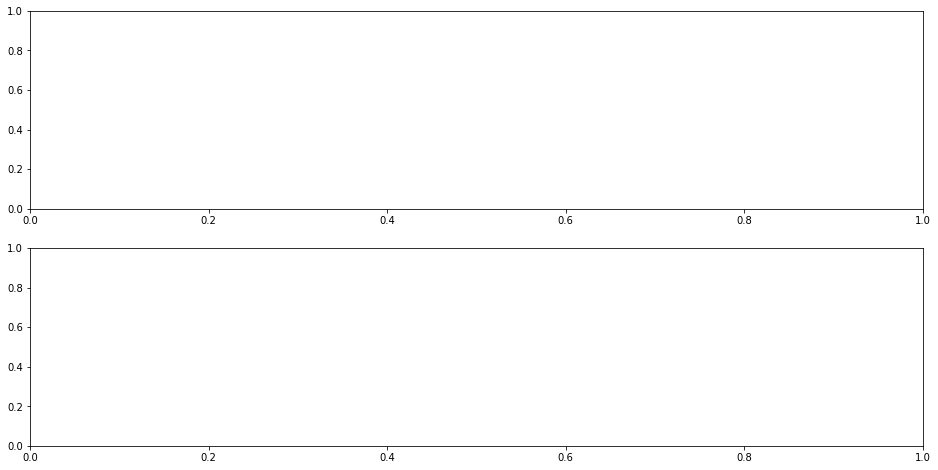

In [537]:
fig, ax = plt.subplots(2, figsize=(16, 8))

X_test = np.linspace(-1, 2, 300)
loss = expit(X_test * log_reg.coef_ + log_reg.intercept_).ravel()
ax[0].plot(X_test, loss, color='red', linewidth=3)
ax[0].scatter(x_1,yhat)
ax[0].set_ylabel('probability')
ax[0].set_xlabel('tGravityAcc-min()-Y')

ax[1].plot(X_test, loss, color='red', linewidth=3)
ax[1].set_ylabel('probability')
ax[1].set_xlabel('tGravityAcc-min()-Y')
ax[1].scatter(prediction,yhat)

## Task 4
- Try to fit Binary Logistic Regression with all the features? How many are significant?

### For Lasso and Rdige there needs to be a linear relationship between X's and Y's, so to reduce here use information

In [666]:
full_data = pd.concat([features,targets], axis = 1)

In [667]:
full_data.columns = full_data.columns.astype(str)
full_data.drop(full_data.columns[-2], axis = 1, inplace = True)
full_data.head()

,1,2,3,4,5,6,7,8,9,10,...,552,553,554,555,556,557,558,559,560,binary
0,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,0
1,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,0
2,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,0
3,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,-0.576159,...,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,0
4,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,-0.569174,...,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,0


In [669]:
IV_Table = iv_woe(data = full_data, target = 'binary', bins=10, show_woe = False)

Information value of 1 is 1.260206
Information value of 2 is 1.000392
Information value of 3 is inf
Information value of 4 is inf
Information value of 5 is inf
Information value of 6 is inf
Information value of 7 is inf
Information value of 8 is inf
Information value of 9 is inf
Information value of 10 is inf
Information value of 11 is inf
Information value of 12 is inf
Information value of 13 is inf
Information value of 14 is inf
Information value of 15 is inf
Information value of 16 is inf
Information value of 17 is inf
Information value of 18 is inf
Information value of 19 is inf
Information value of 20 is inf


/home/david/.local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Information value of 21 is inf
Information value of 22 is inf
Information value of 23 is inf
Information value of 24 is inf
Information value of 25 is inf
Information value of 26 is 2.12126
Information value of 27 is 0.690142
Information value of 28 is 0.358424
Information value of 29 is 2.394199
Information value of 30 is 1.884893
Information value of 31 is 0.195916
Information value of 32 is 0.021954
Information value of 33 is 2.008959
Information value of 34 is 1.954897
Information value of 35 is 0.393127
Information value of 36 is 0.096088
Information value of 37 is 1.358119
Information value of 38 is 0.268149
Information value of 39 is 0.646449
Information value of 40 is inf
Information value of 41 is inf
Information value of 42 is inf
Information value of 43 is inf
Information value of 44 is inf
Information value of 45 is inf
Information value of 46 is inf
Information value of 47 is inf
Information value of 48 is inf
Information value of 49 is inf
Information value of 50 is inf
I

Information value of 272 is inf
Information value of 273 is inf
Information value of 274 is inf
Information value of 275 is inf
Information value of 276 is inf
Information value of 277 is 5.782603
Information value of 278 is 4.150484
Information value of 279 is 3.575229
Information value of 280 is inf
Information value of 281 is inf
Information value of 282 is inf
Information value of 283 is inf
Information value of 284 is inf
Information value of 285 is inf
Information value of 286 is inf
Information value of 287 is inf
Information value of 288 is inf
Information value of 289 is inf
Information value of 290 is 7.630862
Information value of 291 is 2.010896
Information value of 292 is 0.836312
Information value of 293 is 2.321994
Information value of 294 is 0.422484
Information value of 295 is 0.326312
Information value of 296 is 2.693018
Information value of 297 is 2.272145
Information value of 298 is 0.889122
Information value of 299 is 0.788933
Information value of 300 is 0.333611
In

Information value of 539 is 0.401869
Information value of 540 is 0.336614
Information value of 541 is inf
Information value of 542 is inf
Information value of 543 is inf
Information value of 544 is inf
Information value of 545 is 7.562845
Information value of 546 is inf
Information value of 547 is inf
Information value of 548 is inf
Information value of 549 is inf
Information value of 550 is 2.189641
Information value of 551 is 0.695911
Information value of 552 is 0.266016
Information value of 553 is 0.204749
Information value of 554 is 1.780227
Information value of 555 is 1.330907
Information value of 556 is 2.419921
Information value of 557 is 0.135055
Information value of 558 is inf
Information value of 559 is inf
Information value of 560 is inf


,Variable,IV
0,1,1.260206
0,2,1.000392
0,3,inf
0,4,inf
0,5,inf
...,...,...
0,556,2.419921
0,557,0.135055
0,558,inf
0,559,inf


In [671]:
# 559 -> 539 -> 160
IV_Table = IV_Table[(IV_Table['IV'] > 0.1)]
IV_Table = IV_Table[(IV_Table['IV'] != np.inf)]
IV_Table

,Variable,IV
0,1,1.260206
0,2,1.000392
0,26,2.121260
0,27,0.690142
0,28,0.358424
...,...,...
0,553,0.204749
0,554,1.780227
0,555,1.330907
0,556,2.419921


In [672]:
reduced_features = features[IV_Table['Variable'].astype(int)]

In [673]:
reduced_features

,1,2,26,27,28,29,30,31,33,34,...,540,545,550,551,552,553,554,555,556,557
0,-0.020294,-0.132905,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,0.278851,-0.465085,...,0.374605,-0.991048,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446
1,-0.016411,-0.123520,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,0.085988,-0.022153,...,-0.720015,-0.994440,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511
2,-0.019467,-0.113462,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,0.239281,-0.136204,...,-0.871914,-0.995866,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529
3,-0.026201,-0.123283,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,0.294938,-0.306081,...,-0.511217,-0.995732,-0.936508,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366
4,-0.016570,-0.115362,-0.131208,0.191161,0.086904,0.257615,-0.272505,0.434728,0.439744,-0.269069,...,-0.830702,-0.997418,-0.936508,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.057193,-0.181233,0.426433,-0.078255,-0.056751,-0.094106,0.099141,-0.119821,-0.425386,0.267986,...,-0.551898,-0.925241,-0.904762,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619
7348,-0.007749,-0.147468,0.149854,0.206839,-0.154722,0.032725,-0.057240,0.034260,-0.364480,0.121335,...,-0.277183,-0.761880,-0.904762,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219
7349,-0.017011,-0.045022,0.200784,0.063584,-0.017019,-0.004323,-0.023053,0.119962,-0.420093,0.197763,...,0.313280,-0.692582,-0.904762,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169
7350,-0.018843,-0.158281,0.296546,0.009588,-0.038354,-0.277801,0.201032,0.101761,-0.438356,0.250837,...,-0.042502,-0.886154,-0.904762,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479


In [674]:
x_all = reduced_features.values
#x_all = features[[54,55,56,57,58,59,60,500]].values
y = targets['binary'].values

In [675]:
x_all.shape

(7352, 160)

In [676]:
y.shape

(7352,)

### sklearn LogisticRegression

In [677]:
log_reg_all = LogisticRegression(penalty='l2')
log_reg_all.fit(x_all,y)
y_pred=log_reg_all.predict(x_all)

In [679]:
cnf_matrix = metrics.confusion_matrix(y, y_pred)
cnf_matrix

array([[4065,    2],
       [   1, 3284]])

In [680]:
print("Accuracy:",metrics.accuracy_score(y, prediction ))    
print("Precision:",metrics.precision_score(y, prediction ))   
print("Recall:",metrics.recall_score(y, prediction ))  

Accuracy: 0.7097388465723613
Precision: 0.664569631112382
Recall: 0.7074581430745814


In [681]:
x_all = reduced_features.values
y = targets['binary'].values

In [682]:
reduced_features

,1,2,26,27,28,29,30,31,33,34,...,540,545,550,551,552,553,554,555,556,557
0,-0.020294,-0.132905,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,0.278851,-0.465085,...,0.374605,-0.991048,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446
1,-0.016411,-0.123520,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,0.085988,-0.022153,...,-0.720015,-0.994440,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511
2,-0.019467,-0.113462,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,0.239281,-0.136204,...,-0.871914,-0.995866,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529
3,-0.026201,-0.123283,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,0.294938,-0.306081,...,-0.511217,-0.995732,-0.936508,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366
4,-0.016570,-0.115362,-0.131208,0.191161,0.086904,0.257615,-0.272505,0.434728,0.439744,-0.269069,...,-0.830702,-0.997418,-0.936508,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.057193,-0.181233,0.426433,-0.078255,-0.056751,-0.094106,0.099141,-0.119821,-0.425386,0.267986,...,-0.551898,-0.925241,-0.904762,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619
7348,-0.007749,-0.147468,0.149854,0.206839,-0.154722,0.032725,-0.057240,0.034260,-0.364480,0.121335,...,-0.277183,-0.761880,-0.904762,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219
7349,-0.017011,-0.045022,0.200784,0.063584,-0.017019,-0.004323,-0.023053,0.119962,-0.420093,0.197763,...,0.313280,-0.692582,-0.904762,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169
7350,-0.018843,-0.158281,0.296546,0.009588,-0.038354,-0.277801,0.201032,0.101761,-0.438356,0.250837,...,-0.042502,-0.886154,-0.904762,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479


# PCA

In [683]:
pca = PCA(n_components=2)
pca.fit(reduced_features)
reduced = pca.fit_transform(reduced_features)

In [684]:
pca.explained_variance_[pca.explained_variance_>1]

array([2.25242009, 1.24266252])

In [685]:
PCA_df = pd.DataFrame(reduced)
PCA_df.columns = ['PC1','PC2']

In [686]:
PCA_df

,PC1,PC2
0,-1.192242,2.270564
1,-1.412692,0.888528
2,-1.377594,0.487818
3,-1.910551,0.146030
4,-2.220854,-0.068463
...,...,...
7347,2.542056,0.276752
7348,2.174976,0.437768
7349,2.589943,0.920482
7350,2.850668,0.824102


In [687]:
x_all = PCA_df.values
y = targets['binary'].values

### statsmodel

In [689]:
log_reg_sm_all = sm.Logit(y, x_all).fit() 

Optimization terminated successfully.
         Current function value: 0.167909
         Iterations 8


In [690]:
yhat_all = log_reg_sm_all.predict(x_all) 
prediction = list(map(round, yhat_all)) 

In [691]:
print(log_reg_sm_all.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 7352
Model:                          Logit   Df Residuals:                     7350
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Aug 2020   Pseudo R-squ.:                  0.7558
Time:                        20:09:12   Log-Likelihood:                -1234.5
converged:                       True   LL-Null:                       -5054.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0644      0.052     39.527      0.000       1.962       2.167
x2            -2.9483      0.085    -34.517      0.000      -3.116      -2.781


In [692]:
cnf_matrix = metrics.confusion_matrix(y, prediction)
cnf_matrix

array([[3629,  438],
       [  10, 3275]])

In [693]:
print("Accuracy:",metrics.accuracy_score(y, prediction ))    
print("Precision:",metrics.precision_score(y, prediction ))   
print("Recall:",metrics.recall_score(y, prediction ))  

Accuracy: 0.9390642002176278
Precision: 0.8820360894155669
Recall: 0.9969558599695586


## Task 5
Now, let's fit Multinomial Logistic regression to predict all categories. Firstly, we can start with **Univariate** model for these features number separately:
+ 4
+ 54
- 19

Check the contingency matrix to see the effect of particular features!! (each feature can be good in predicting different categories)

In [694]:
x_4 = features[4].values.reshape(-1,1)
x_54 = features[54].values.reshape(-1,1)
x_19 = features[19].values.reshape(-1,1)
x = features[[4,54,19]].values
x_scaled = preprocessing.scale(x)
y = targets[0].values

### feature 4

In [695]:
log_reg_4 = LogisticRegression(penalty='l2', multi_class = 'multinomial')

In [696]:
log_res_4 = log_reg.fit(x_4,y)
y_pred_4 = log_res_4.predict(x_4)

In [697]:
cnf_matrix = metrics.confusion_matrix(y, y_pred_4)
cnf_matrix

array([[ 987,    0,  238,    0,    1,    0],
       [ 813,    0,  260,    0,    0,    0],
       [ 610,    0,  375,    0,    1,    0],
       [  27,    0,    1,    0,   39, 1219],
       [   6,    0,    0,    0,   25, 1343],
       [  25,    0,    5,    0,   28, 1349]])

In [698]:
log_res_4.score(x_4,y)

0.3721436343852013

### feature 54

In [699]:
log_reg_54 = LogisticRegression(penalty='l2', multi_class = 'multinomial')

In [700]:
log_res_54 = log_reg.fit(x_54,y)
y_pred_54 = log_res_54.predict(x_54)

In [701]:
cnf_matrix = metrics.confusion_matrix(y, y_pred_54)
cnf_matrix

array([[   0,  289,    0,  254,  683,    0],
       [   0,  460,    0,  108,  505,    0],
       [   0,  258,    0,  197,  525,    6],
       [   0,   80,    0,  569,  367,  270],
       [   0,  297,    0,  425,  634,   18],
       [   0,   93,    0,  130,   49, 1135]])

In [702]:
log_res_54.score(x_54,y)

0.38057671381936886

### feature 19

In [703]:
log_reg_19 = LogisticRegression(penalty='l2', multi_class = 'multinomial')

In [704]:
log_res_19 = log_reg.fit(x_19,y)
y_pred_19 = log_res_19.predict(x_19)

In [705]:
cnf_matrix = metrics.confusion_matrix(y, y_pred_19)
cnf_matrix

array([[1059,    0,  152,    0,    0,   15],
       [ 872,    0,  192,    0,    0,    9],
       [ 308,    0,  677,    0,    0,    1],
       [   1,    0,    0,    0, 1137,  148],
       [   0,    0,    0,    0, 1230,  144],
       [  16,    0,    3,    0,  851,  537]])

In [706]:
log_res_19.score(x_19, y)

0.4764689880304679

### Multivariate 

In [725]:
x = PCA_df.values
y = targets[0].values

In [726]:
log_reg_mult = LogisticRegression(penalty ='l2' ,solver = 'saga', multi_class = 'multinomial',max_iter = 500000000)

In [727]:
log_res_mult = log_reg.fit(x,y)
y_pred_mult = log_res_mult.predict(x)

In [728]:
cnf_matrix = metrics.confusion_matrix(y, y_pred_mult)
cnf_matrix

array([[880, 160, 133,   0,  53,   0],
       [ 91, 849,  82,   0,  51,   0],
       [544, 177, 256,   0,   9,   0],
       [ 24,  36,   0, 217, 400, 609],
       [ 62,  71,   4, 151, 586, 500],
       [ 21,  33,   0, 224, 464, 665]])

In [729]:
log_res_mult.score(x, y)

0.4696681175190424

## Task 6

Fit the Multinomial Logistic Regression model again. Now, try to choose **all** important features we have in the dataset. Who will get the best predictions with the smallest number of features?

In [742]:
#x = PCA_df.values
x = reduced_features.values
#x = features.values
y = targets[0].values

In [743]:
x.shape

(7352, 160)

In [744]:
y.shape

(7352,)

In [745]:
log_reg_all = LogisticRegression(penalty ='l2' ,solver = 'saga', multi_class = 'multinomial',max_iter = 10000)

In [746]:
log_reg_all.fit(x,y)
y_pred = log_reg_all.predict(x)

In [747]:
cnf_matrix = metrics.confusion_matrix(y, y_pred)
cnf_matrix

array([[1218,    6,    1,    0,    1,    0],
       [   3, 1062,    8,    0,    0,    0],
       [   4,    2,  980,    0,    0,    0],
       [   0,    1,    0, 1105,   88,   92],
       [   0,    1,    0,   79, 1270,   24],
       [   0,    0,    1,   76,   30, 1300]])

In [749]:
log_reg_all.score(x, y)

0.9432807399347116

## Task 7 (Stretch)
Create your own function for Stepwise selection. Use either sklearn or statsmodel.

In [769]:
full_data = pd.concat([features,targets], axis = 1)

In [770]:
full_data.columns = full_data.columns.astype(str)
full_data.drop(full_data.columns[-2], axis = 1, inplace = True)

In [771]:
IV_Table = iv_woe(data = full_data, target = 'binary', bins=10, show_woe = False)

/home/david/.local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [772]:
IV_Table = IV_Table[(IV_Table['IV'] > 0.1)]
IV_Table = IV_Table[(IV_Table['IV'] != np.inf)]
reduced_features = features[IV_Table['Variable'].astype(int)]
reduced_features

,1,2,26,27,28,29,30,31,33,34,...,540,545,550,551,552,553,554,555,556,557
0,-0.020294,-0.132905,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,0.278851,-0.465085,...,0.374605,-0.991048,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446
1,-0.016411,-0.123520,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,0.085988,-0.022153,...,-0.720015,-0.994440,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511
2,-0.019467,-0.113462,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,0.239281,-0.136204,...,-0.871914,-0.995866,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529
3,-0.026201,-0.123283,0.074840,0.198204,-0.264307,0.072545,-0.155320,0.323154,0.294938,-0.306081,...,-0.511217,-0.995732,-0.936508,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366
4,-0.016570,-0.115362,-0.131208,0.191161,0.086904,0.257615,-0.272505,0.434728,0.439744,-0.269069,...,-0.830702,-0.997418,-0.936508,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,-0.057193,-0.181233,0.426433,-0.078255,-0.056751,-0.094106,0.099141,-0.119821,-0.425386,0.267986,...,-0.551898,-0.925241,-0.904762,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619
7348,-0.007749,-0.147468,0.149854,0.206839,-0.154722,0.032725,-0.057240,0.034260,-0.364480,0.121335,...,-0.277183,-0.761880,-0.904762,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219
7349,-0.017011,-0.045022,0.200784,0.063584,-0.017019,-0.004323,-0.023053,0.119962,-0.420093,0.197763,...,0.313280,-0.692582,-0.904762,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169
7350,-0.018843,-0.158281,0.296546,0.009588,-0.038354,-0.277801,0.201032,0.101761,-0.438356,0.250837,...,-0.042502,-0.886154,-0.904762,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479


In [758]:
x = reduced_features.values
y = targets['binary'].values

In [776]:
#log_reg_sm_all = sm.Logit(y, x).fit() 

In [ ]:
yhat_all = log_reg_sm_all.predict(x_all) 
prediction = list(map(round, yhat_all)) 